In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# CSV file 
df = pd.read_csv("C:/Users/DELL/Desktop/f1_pitstops_2018_2024.csv")


**The first step is to clean and pre process the data so that data shall be ready for Ml models**

Here what i did is that i simply took the quantitative columns and fill the null in the columns by median also check the columns if any dupliate drop and same for the rows and got the unnull columns at the end.

In [8]:
print("Total Columns:")
print(df.columns.tolist())


#Check for the duplicate column
if 'TotalPitStops' in df.columns and 'Total Pit Stops' in df.columns:
    are_equal = np.allclose(df['TotalPitStops'], df['Total Pit Stops'], equal_nan=True)
    print(f"\nAre 'TotalPitStops' and 'Total Pit Stops' equal? {are_equal}")
    if are_equal:
        df.drop(columns=['Total Pit Stops'], inplace=True)  # Drop duplicate column

#List for numerical columns
numerical_cols = [
    'Season', 'Round', 'Laps', 'Position', 'TotalPitStops', 'AvgPitStopTime',
    'Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH',
    'Lap Time Variation', 'Tire Usage Aggression', 'Fast Lap Attempts',
    'Position Changes', 'Driver Aggression Score', 'Stint',
    'Stint Length', 'Pit_Lap'
]

#Fill nulls with median
for col in numerical_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

#Drop duplicate rows
df.drop_duplicates(inplace=True)

#Final confirmation
print(f"\n Data cleaned. Final shape: {df.shape}")

print("\nNull Counts:")
print(df.isnull().sum())


Total Columns:
['Season', 'Round', 'Circuit', 'Driver', 'Constructor', 'Laps', 'Position', 'TotalPitStops', 'AvgPitStopTime', 'Race Name', 'Date', 'Time_of_race', 'Location', 'Country', 'Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Total Pit Stops', 'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score', 'Abbreviation', 'Stint', 'Tire Compound', 'Stint Length', 'Pit_Lap', 'Pit_Time']

Are 'TotalPitStops' and 'Total Pit Stops' equal? False

 Data cleaned. Final shape: (7374, 30)

Null Counts:
Season                       0
Round                        0
Circuit                      0
Driver                       0
Constructor                  0
Laps                         0
Position                     0
TotalPitStops                0
AvgPitStopTime               0
Race Name                  373
Date                       373
Time_of_race               373
Location                   373
Country                 

**As we filled the missing rows in the quantitative columns now we will do that for the qualitative columns fill the missing rows.**

Here we fill the missing rows with the unknown whose size greater then 10% and if less then 10% we will use mode to fill it.

In [10]:
qualitative_cols = [
    'Circuit', 'Driver', 'Constructor', 'Race Name', 'Date', 'Time_of_race',
    'Location', 'Country', 'Abbreviation', 'Tire Compound', 'Pit_Time'
]

#Handle nulls in qualitative columns
for col in qualitative_cols:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            # If less than 10% of values are missing, fill with mode
            if null_count / len(df) < 0.1:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
            else:
                # Otherwise fill with 'Unknown'
                df[col].fillna("Unknown", inplace=True)

#Final check: Are there any nulls left in the dataset?
total_nulls = df.isnull().sum().sum()

if total_nulls == 0:
    print("\n Dataset is now completely clean — no missing values!")
else:
    print(f"\n⚠ Dataset still has {total_nulls} missing values. Consider checking specific columns.")

print(df.isnull().sum())



 Dataset is now completely clean — no missing values!
Season                     0
Round                      0
Circuit                    0
Driver                     0
Constructor                0
Laps                       0
Position                   0
TotalPitStops              0
AvgPitStopTime             0
Race Name                  0
Date                       0
Time_of_race               0
Location                   0
Country                    0
Air_Temp_C                 0
Track_Temp_C               0
Humidity_%                 0
Wind_Speed_KMH             0
Lap Time Variation         0
Total Pit Stops            0
Tire Usage Aggression      0
Fast Lap Attempts          0
Position Changes           0
Driver Aggression Score    0
Abbreviation               0
Stint                      0
Tire Compound              0
Stint Length               0
Pit_Lap                    0
Pit_Time                   0
dtype: int64


**Now here we are using label encoder to make our qualitative data in form of numerical so the data ready for Ml modles**

In [11]:
#Copy original dataframe
df_encoded = df.copy()


#Encode Driver as a Feature

label_encoder_driver = LabelEncoder()
df_encoded['Driver_Encoded'] = label_encoder_driver.fit_transform(df_encoded['Driver'])


#Encode Abbreviation (if exists)

if 'Abbreviation' in df_encoded.columns:
    label_encoder_abbr = LabelEncoder()
    df_encoded['Abbreviation'] = label_encoder_abbr.fit_transform(df_encoded['Abbreviation'])


#One-Hot Encode Nominal Features

one_hot_cols = ['Constructor', 'Country', 'Tire Compound', 'Circuit', 'Location', 'Race Name']

df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)


#Set up Final X and y

#Drop unused columns
df_encoded.drop(columns=['Driver'], inplace=True)

#Set X and y
X = df_encoded.drop(columns=['Position'])  # Predictor features
y = df_encoded['Position']                 # Target variable

print(" Encoding complete. Feature shape:", X.shape)


 Encoding complete. Feature shape: (7374, 154)


**The second step is to do visualization and take out the insights**

Use the heatmap to see the correlation of different predictors with the position

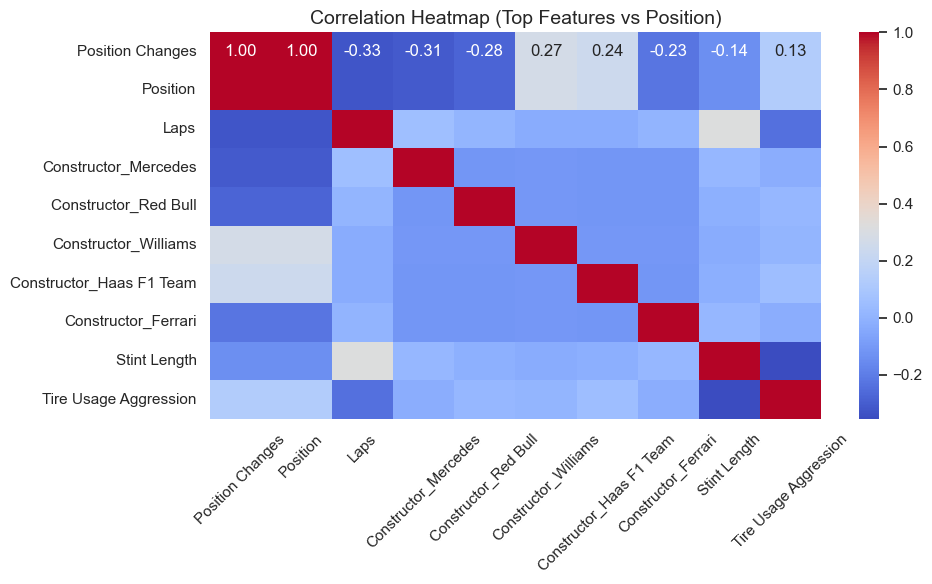

In [13]:
#Set visual style
sns.set(style="whitegrid")

#Use Position as target
correlation = df_encoded.corr(numeric_only=True)

#Select top features most correlated with Position (absolute value)
top_corr = correlation['Position'].abs().sort_values(ascending=False).head(10).index

#Extract those columns
top_corr_df = df_encoded[top_corr]

#Heatmap Plot
plt.figure(figsize=(10, 6))
sns.heatmap(top_corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Top Features vs Position)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**The third step do train the Ml models and take out the result**

In [19]:
#Step 1: Define features and target
y = df_encoded['Position']
X = df_encoded.drop(columns=['Position'])

#Step 2: Drop non-numeric columns
non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
print("Dropping non-numeric columns:", non_numeric_cols)
X = X.drop(columns=non_numeric_cols)

#Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Step 4: Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 5: Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

#Step 6: Evaluate models
print("\n Model Comparison (Accuracy & F1 Score):")
for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')

    print(f"\n {name}")
    print(f" Accuracy: {round(acc, 4)}")
    print(f" F1 Score: {round(f1, 4)}")


Dropping non-numeric columns: ['Date', 'Time_of_race', 'Pit_Time']

 Model Comparison (Accuracy & F1 Score):

 Logistic Regression
 Accuracy: 0.442
 F1 Score: 0.4375

 Random Forest
 Accuracy: 0.939
 F1 Score: 0.9389

 KNN
 Accuracy: 0.2834
 F1 Score: 0.2783

 Naive Bayes
 Accuracy: 0.6569
 F1 Score: 0.6547


**The 4th step to select the best model form the above modles**

Random Forest model outperforms all other models with a very high accuracy of 93.76% and an F1 score of 93.73%, indicating strong performance on both correct predictions and class balance.

**The fifth step is to draw confusion matrix and compare the f1 and accuraccy of all**

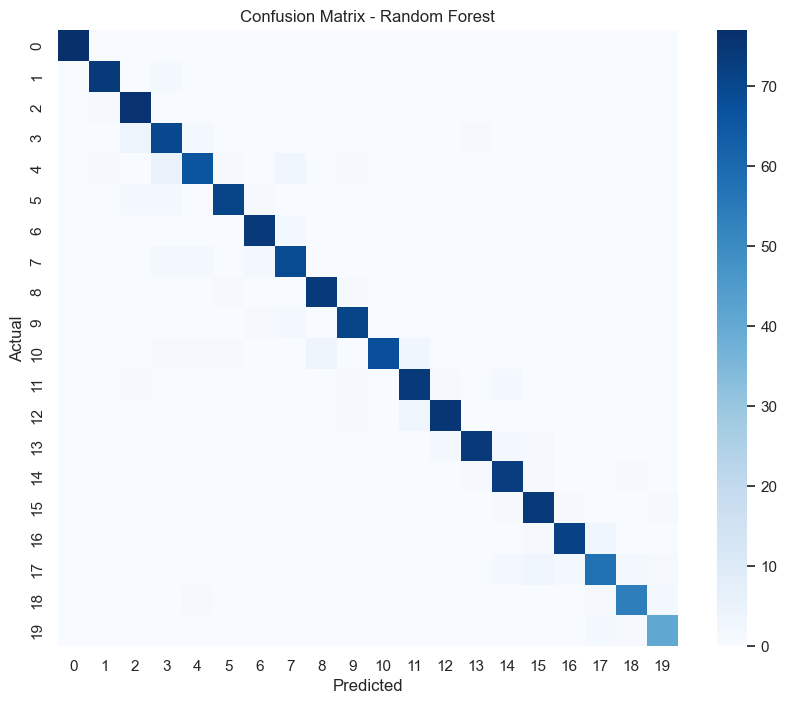

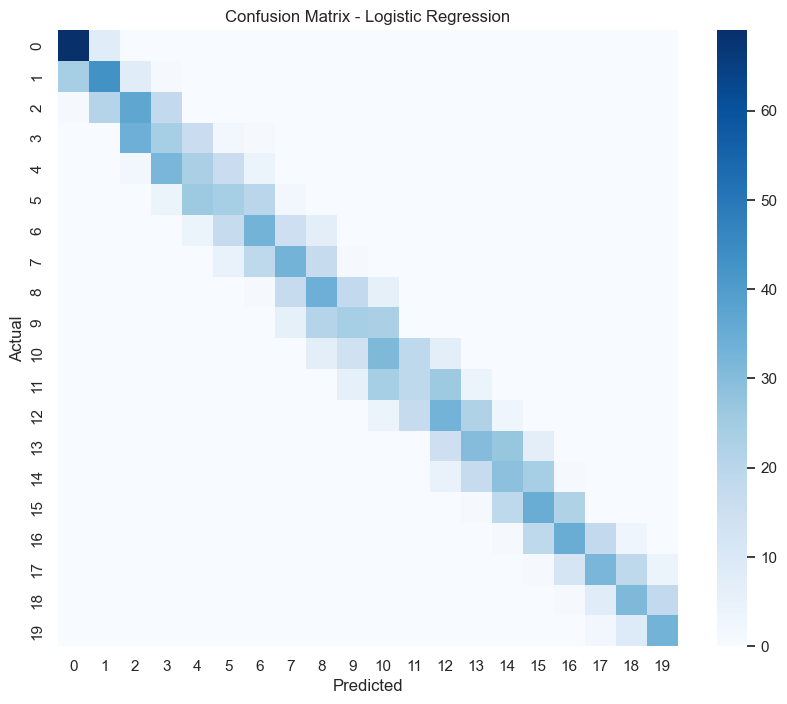

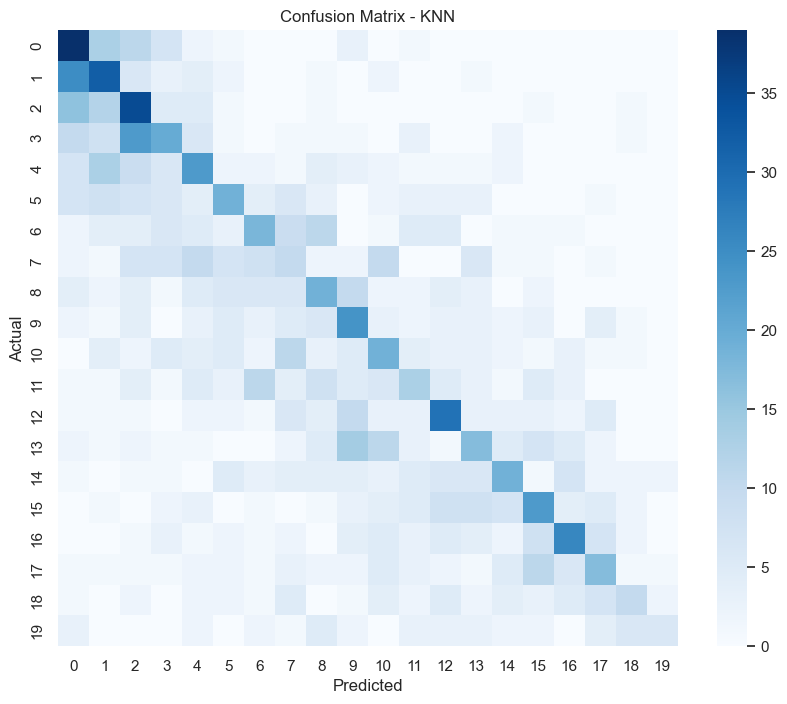

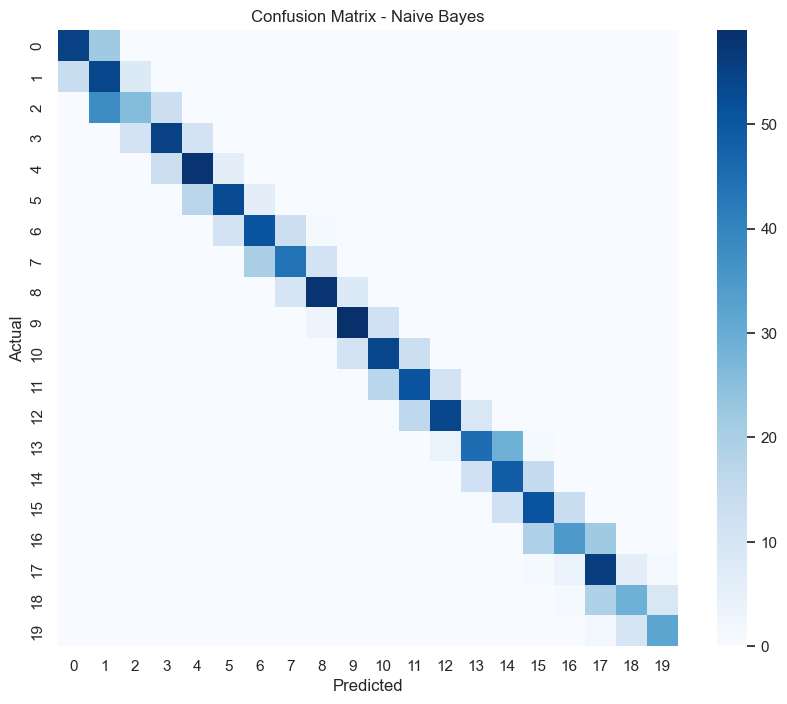

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(model, X_test, y_test, scaled=False, model_name='Model'):
    preds = model.predict(X_test if not scaled else scaler.transform(X_test))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for each model
plot_conf_matrix(models["Random Forest"], X_test, y_test, scaled=False, model_name="Random Forest")
plot_conf_matrix(models["Logistic Regression"], X_test, y_test, scaled=True, model_name="Logistic Regression")
plot_conf_matrix(models["KNN"], X_test, y_test, scaled=True, model_name="KNN")
plot_conf_matrix(models["Naive Bayes"], X_test, y_test, scaled=False, model_name="Naive Bayes")
